This notebook uses OpenAI baselines to train an (Inverted pendulum/Cartpole/Acrobot) to balance. We expect the policy around the equilibruim to be somewhat linear. This notebook investigates exactly how linear and trys to "extract" the linearity from the network. 

In [1]:
from baselines.common.cmd_util import make_mujoco_env, mujoco_arg_parser
from baselines.common import tf_util as U
import tensorflow as tf
from baselines import logger
import os
import sys
from baselines.ppo1 import mlp_policy, pposgd_simple

import gym
import seagul.envs
import policies.mlp_relu_policy as mlp_relu_policy

import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

#Needed for saving 
import errno, datetime, time, inspect

def train(env_id, num_timesteps, seed=0):

    U.make_session(num_cpu=16).__enter__()
    
    def policy_fn(name, ob_space, ac_space):
        #return mlp_policy.MlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=64, num_hid_layers=64)
        return mlp_relu_policy.ReluMlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=64, num_hid_layers=4)

    env = gym.make(env_id)
    pi = pposgd_simple.learn(env, policy_fn,
            max_timesteps=num_timesteps,
            timesteps_per_actorbatch=2048,
            clip_param=0.2, entcoeff=0.0,
            optim_epochs=10, optim_stepsize=3e-4, optim_batchsize=64,
            gamma=0.99, lam=0.95, schedule='linear',
        )
    env.close()
   
    return pi



def save_results(filename, description = None):
    """ 
    description: saves the results of a run of the second cell (the one that calls train) in this notebook
    
    """

    save_dir = "data/" + filename + "/"
    os.makedirs(save_dir)
    
    if description is None:
        description  = input("please enter a description of the run")
        
    datetime_str = str(datetime.datetime.today())
    datetime_str = datetime_str.replace(" ", "_")
    
    runtime_str = str(datetime.timedelta(seconds = runtime))
    
    readme = open(save_dir + "README.txt", "w+")
    readme.write("datetime: " + datetime_str + "\n\n")
    readme.write("enviroment: " + env_name + "\n\n")
    readme.write("description: " + description + "\n\n")
    readme.write("time_elapsed: " + runtime_str + "\n\n")
    readme.write("num_timesteps: " + str(num_timesteps) + "\n\n")
    readme.write("seed: " + str(seed) + "\n\n")
    readme.close()

    # TODO add code snippets that correspond to the run
    # TODO somehow store the tensorboard logs here after the fact
    
    saver = tf.train.Saver()
    saver.save(tf.get_default_session(), save_dir + filename)
    
    os.rename("./tmp_logs/", save_dir + "tensorboard")
   
env_name = "Pendulum-v0"  
#env_name = "Acrobot-v1"
#env_name = "su_pendulum-v0"
#env_name = "InvertedPendulum-v2"
#env_name = 'InvertedPendulumPyBulletEnv-v0'
#env_name = "su_cartpole_et-v0"
#env_name = "InvertedDoublePendulum-v2"

Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2019-01-16-14-43-04-989747


/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# comment one of these lines to switch between loading weights or training them from scratch
#load_pretrained_network = True
load_pretrained_network = False


if load_pretrained_network: #load the weights
    save_name = 'invertedpendulum_3layer'
    
    pi = train(env_name, num_timesteps=1, seed=0)
    # TODO eventually need to switch to .load_variables() instead of U.load_state() but this didn't work by default for me
    U.load_state(os.getcwd() + '/data/'+ save_name + '/' + save_name)
    
else: #run the RL algorithm
    num_timesteps = 2e5
    seed = 0
    
    print("training")
    
    start_time = time.time()
    
    logger.configure(dir = "./tmp_logs", format_strs=["tensorboard"] )
    with tf.device("/cpu:0"):    
        pi= train(env_name, num_timesteps=num_timesteps, seed=seed)

    runtime = time.time() - start_time

training


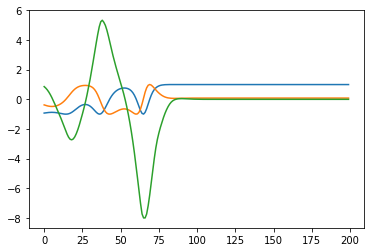

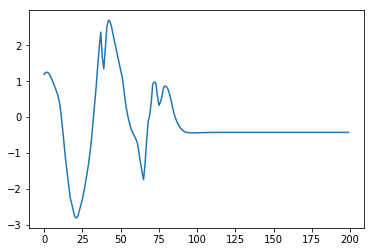

In [5]:
# Plays out a trained policy

env = make_mujoco_env(env_name,seed=0)
ob = env.reset()     

ob_list = []
act_list = []
while True:
    action = pi.act(stochastic=False, ob=ob)[0]
    ob, _, done, _ =  env.step(action)
    
    ob_list.append(ob)
    act_list.append(action)
    #if reward == 1:
    #    print("balanced")
    #env.render()
    if done:
        break
        #ob = env.reset()
        
plt.figure()
plt.plot(ob_list)

plt.figure()
plt.plot(act_list)

In [5]:
 #U.save_state("./saved/5mil_flat")

In [30]:
all_weights = pi.get_variables()

# I'll fix this later..
kernel0 = all_weights[13].value().eval()
bias0   = all_weights[14].value().eval()

kernel1 = all_weights[15].value().eval()
bias1   = all_weights[16].value().eval()

kernel2 = all_weights[17].value().eval()
bias2   = all_weights[18].value().eval()

name_dict = {"kernel0": kernel0, "kernel1":kernel1, "kernel2":kernel2, "bias0":bias0, "bias1":bias1, "bias2":bias2}
scipy.io.savemat("savemat_test", name_dict)

In [3]:
#input_iter = itertools.combinations_with_replacement(range(-10,11),4)
#input_data = np.array([np.array(x) for x in input_iter],dtype='float32')
#output_data = np.array([pi.act(0, x)[0] for x in input_data],dtype='float32')

input_iter = itertools.combinations_with_replacement(range(-10,11),2)
input_data = np.array([np.concatenate((np.zeros(2), np.array(x))) for x in input_iter],dtype='float32')
output_data = np.array([pi.act(0, x)[0] for x in input_data],dtype='float32')

ValueError: cannot reshape array of size 4 into shape (6)

In [4]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()

regr.fit(input_data,output_data.T.flatten())
#regr.fit(input_data,output_data)
#regr.fit(index, output_data.T.flatten())

lin_predict = regr.predict(input_data)
#lin_predict = regr.predict(index)

print("coefs are", regr.coef_)
print("mean sqared error:", mean_squared_error(lin_predict, output_data))

coefs are [-9.296509e+00 -9.336461e+00 -4.431352e-03  3.993816e-02]
mean sqared error: 31.270477


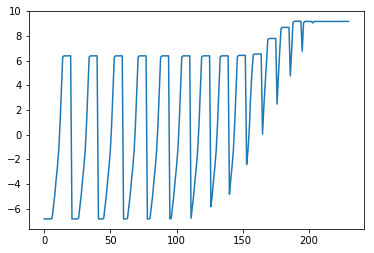

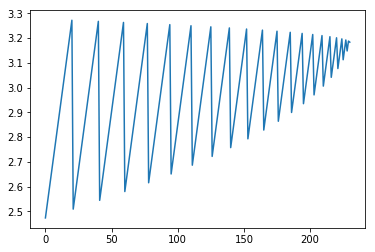

In [5]:
plt.plot(output_data)
plt.figure()
plt.plot(lin_predict)

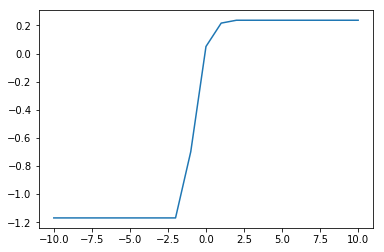

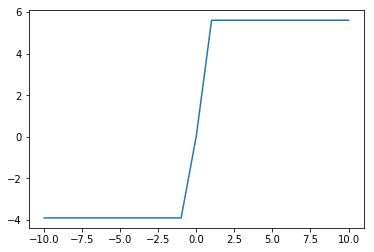

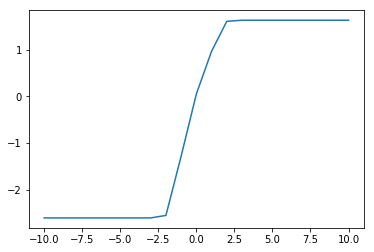

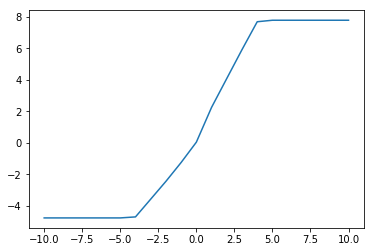

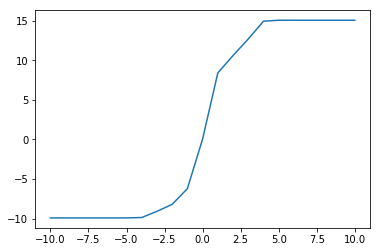

In [6]:
input_data = np.array([[x, 0, 0, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,0], output_data)
plt.figure()

input_data = np.array([[0, x, 0, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,1], output_data)
plt.figure()

input_data = np.array([[0, 0, x, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,2], output_data)
plt.figure()

input_data = np.array([[0, 0, 0, x] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,3], output_data)
plt.figure()

input_data = np.array([[x, x, x, x] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,0], output_data)

In [7]:
x = input_data[:,2]
y = input_data[:,3]
z= output_data.flatten()
z2 = lin_predict.flatten()

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

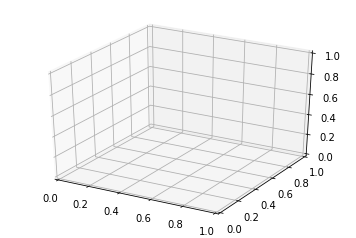

In [8]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');

ax2 = plt.axes(projection='3d')
ax2.plot_trisurf(x, y, z2, cmap='viridis', edgecolor='none');